In [1]:
import matplotlib.pyplot as plt
import numpy as np
from rich.progress import track
from scipy.stats import uniform, norm

from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationType,
    Velocities,
    propagate_trajectories,
    PropagationOptions,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
)
from centrex_trajectories.visualization import plot_beamline
from centrex_trajectories.random_generation import (
    generate_random_coordinates_normal_circle,
    generate_random_coordinates_uniform_circle,
    generate_random_velocities_normal,
)


In [2]:
plt.rcParams.update({"font.size": 14})

# Parameters

## Constants

Dimensions and distances here are taken from Oskari Timgren's thesis, section 8.2.4.

In [3]:
n_trajectories = 100_000_000
options = PropagationOptions(verbose=False, n_cores=8)
gravity = Gravity(0, -9.81, 0)
particle = TlF()


in_to_m = 25.4e-3

# lengths
rc_length = 12.5 * in_to_m
spa_length = 12.5 * in_to_m
spb_length = 12.5 * in_to_m
interaction_length = 3.0
spc_length = 12.5 * in_to_m

# distances
cone_distance = 0.325 * in_to_m
shield4k_distance = (0.325 + 1 + 0.375) * in_to_m
shield40k_distance = shield4k_distance + (0.25 + 1.25) * in_to_m
beambox_distance = shield40k_distance + (0.25 + 2.5) * in_to_m
rc_distance = beambox_distance + 0.75 * in_to_m
spa_distance = rc_distance + rc_length
eql_distance = spa_distance + spa_length


aperture_cone_radius = 0.232 * in_to_m / 2
aperture_4k_radius = 1 * in_to_m / 2
aperture_40k_radius = 1 * in_to_m / 2
aperture_beambox_radius = 4 * in_to_m / 2
aperture_interaction_width = 1.8e-2
aperture_interaction_height = 10e-2
aperture_det_width = 1e-2
aperture_det_height = 3e-2

eql_radius = 1.75 * in_to_m / 2
eql_voltage = 30_000  # V
eql_length = 0.6  # m

v_forward = 200  # m/s
sigma_v_forward = 13  # m/s
sigma_v_transverse = 57  # m/s

freezing_diameter = 0.02
z_freezing = 0.25 * in_to_m


# measured
# v_forward = 184  # m/s
# sigma_v_forward = 16  # m/s
# sigma_v_transverse = 39.4  # m/s

# acme distribution modified to our cell opening size (0.25" vs 5 mm for ACME)
sigma_x = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution
sigma_y = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution


In [7]:
# origin = generate_random_coordinates_uniform_circle(
#     radius=freezing_diameter / 2, number=n_trajectories, z=z_freezing
# )

origin = generate_random_coordinates_normal_circle(
    sigma=sigma_x, number=n_trajectories, x=0, y=0, z=z_freezing
)

velocities = generate_random_velocities_normal(
    vx=0,
    vy=0,
    vz=v_forward,
    sigma_vx=sigma_v_transverse,
    sigma_vy=sigma_v_transverse,
    sigma_vz=sigma_v_forward,
    number=n_trajectories,
)


In [ ]:
def calculate_distances(
    eql_length: float,
) -> tuple[
    float,
    float,
    float,
    float,
]:
    spb_distance = eql_distance + eql_length
    interaction_distance = spb_distance + spb_length
    spc_distance = interaction_distance + interaction_length
    det_distance = spc_distance + spc_length
    return spb_distance, interaction_distance, spc_distance, det_distance


In [ ]:
from centrex_trajectories.beamline_objects import PlateElectrodes

(
    spb_distance,
    interaction_distance,
    spc_distance,
    det_distance,
) = calculate_distances(eql_length)

cone = Section(
    name="SKIMMER",
    # objects=[],
    objects=[CircularAperture(0, 0, 0.325 * in_to_m, r=aperture_cone_radius)],
    start=0,
    stop=cone_distance,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

fourK = Section(
    name="4K",
    objects=[CircularAperture(0, 0, shield4k_distance, aperture_4k_radius)],
    start=shield4k_distance,
    stop=shield40k_distance,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

fourtyK = Section(
    name="40K",
    objects=[CircularAperture(0, 0, shield40k_distance, aperture_40k_radius)],
    start=shield40k_distance,
    stop=beambox_distance,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

beambox = Section(
    name="BEAMBOX",
    objects=[CircularAperture(0, 0, beambox_distance, aperture_beambox_radius)],
    start=beambox_distance,
    stop=rc_distance,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="RC",
    objects=[],
    start=rc_distance,
    stop=spa_distance,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="SPA",
    objects=[
        CircularAperture(0, 0, eql_distance, eql_radius)
    ],  # insert an aperture to limit throughput to lens
    start=spa_distance,
    stop=eql_distance,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)

eql = ElectrostaticQuadrupoleLens(
    name="EQL",
    objects=[Bore(x=0, y=0, z=eql_distance, length=eql_length, radius=eql_radius)],
    start=eql_distance,
    stop=spb_distance,
    V=eql_voltage,
    R=eql_radius,
    save_collisions=True,
)

spb = Section(
    name="SPB",
    objects=[
        RectangularAperture(
            0,
            0,
            interaction_distance,
            aperture_interaction_width,
            aperture_interaction_height,
        )
    ],
    start=spb_distance,
    stop=interaction_distance,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)

interaction = Section(
    name="INT",
    objects=[
        PlateElectrodes(
            0,
            0,
            interaction_distance,
            length=interaction_length,
            width=10e-2,
            separation=2e-2,
        )
    ],
    start=interaction_distance,
    stop=spc_distance,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)

spc = Section(
    name="SPC",
    objects=[],
    start=spc_distance,
    stop=det_distance,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)

det = Section(
    name="DET",
    objects=[
        RectangularAperture(0, 0, det_distance, aperture_det_width, aperture_det_height)
    ],
    start=det_distance,
    stop=det_distance + 1e-3,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)


In [ ]:
eql = ElectrostaticQuadrupoleLens(
    name="EQL",
    objects=[Bore(x=0, y=0, z=eql_distance, length=eql_length, radius=eql_radius)],
    start=eql_distance,
    stop=spb_distance,
    V=eql_voltage,
    R=eql_radius,
    save_collisions=True,
)

sections_lens = [
    cone,
    fourK,
    fourtyK,
    beambox,
    rc,
    spa,
    eql,
    spb,
    interaction,
    spc,
    det,
]
section_data_lens, trajectories_lens = propagate_trajectories(
    sections_lens,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


In [ ]:
eql_0V = ElectrostaticQuadrupoleLens(
    name="EQL",
    objects=[Bore(x=0, y=0, z=eql_distance, length=eql_length, radius=eql_radius)],
    start=eql_distance,
    stop=spb_distance,
    V=0,
    R=eql_radius,
    save_collisions=True,
)

sections_lens_0V = [
    cone,
    fourK,
    fourtyK,
    beambox,
    rc,
    spa,
    eql_0V,
    spb,
    interaction,
    spc,
    det,
]
section_data_lens_0V, trajectories_lens_0V = propagate_trajectories(
    sections_lens_0V,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


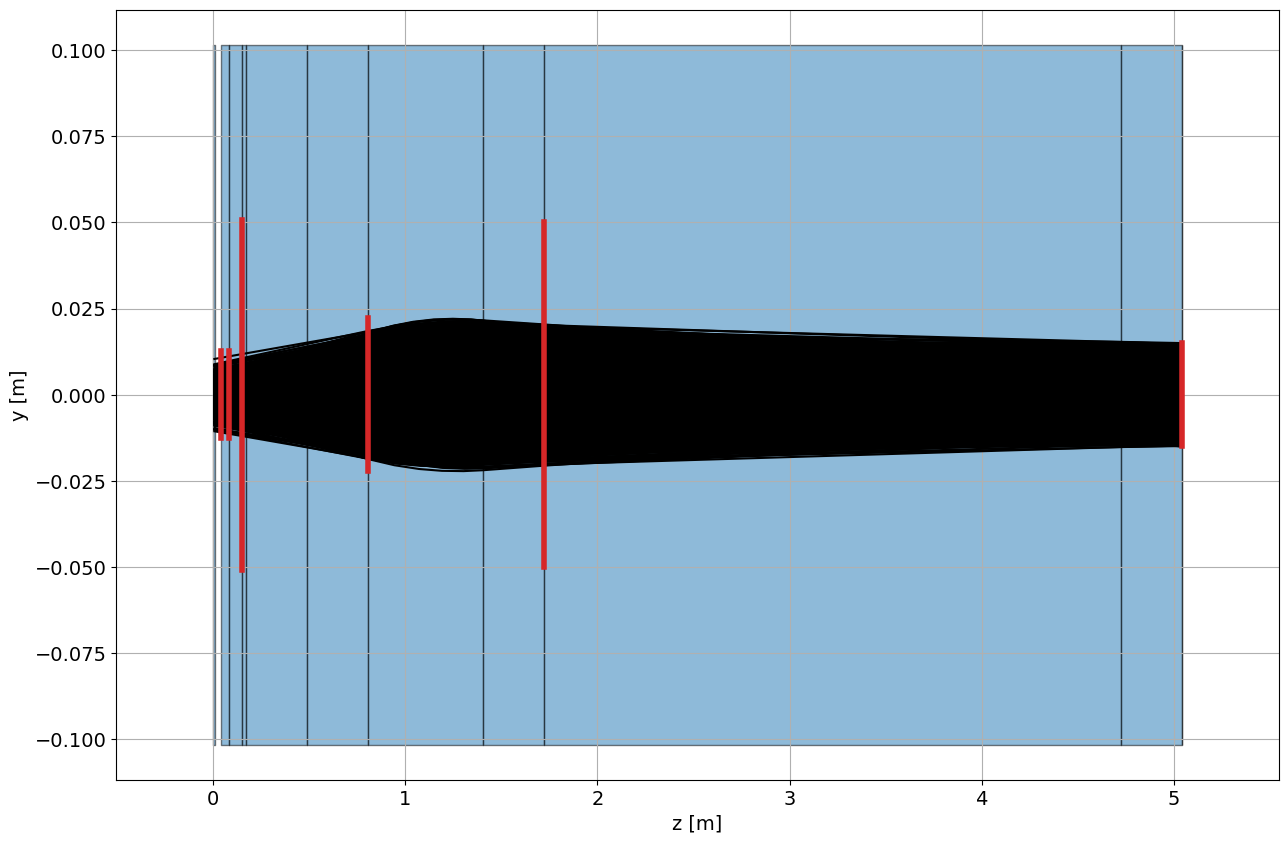

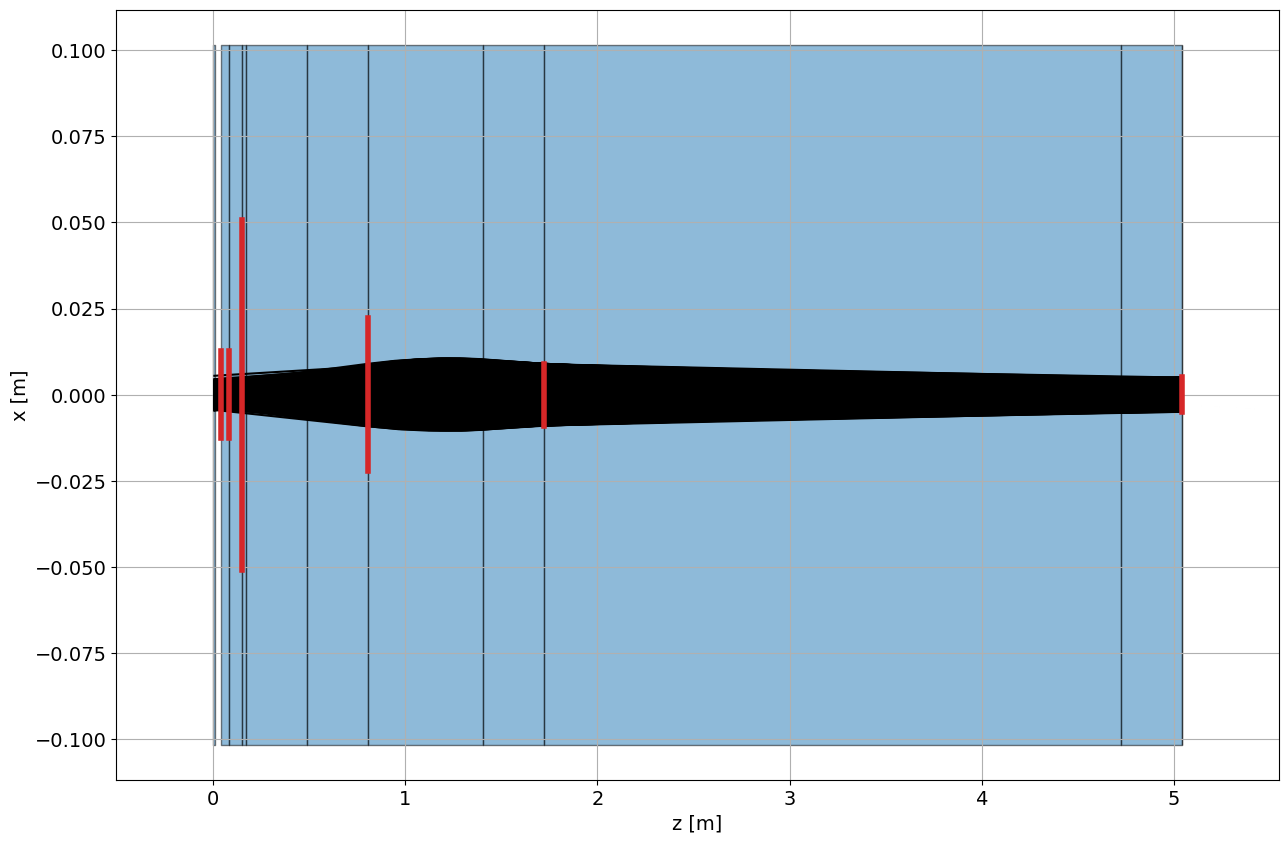

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_lens.items():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections_lens, ax=ax, axis="y")

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_lens.items():
    ax.plot(traj.z, traj.x, color="k")

plot_beamline(sections_lens, ax=ax, axis="x")

ax.set_xlabel("z [m]")
ax.set_ylabel("x [m]")

ax.grid(True)


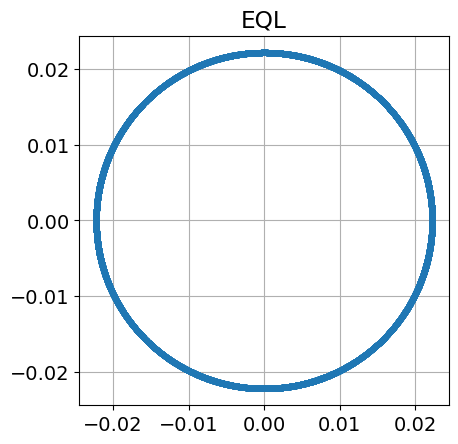

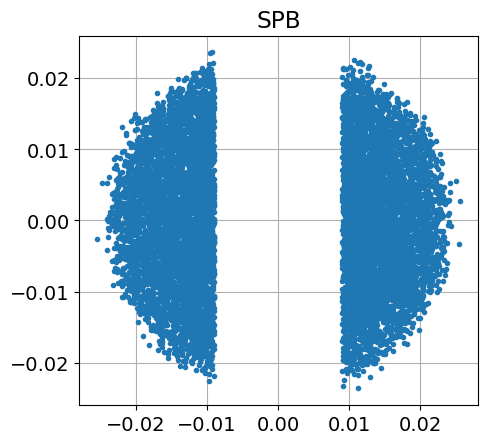

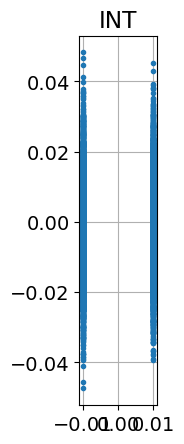

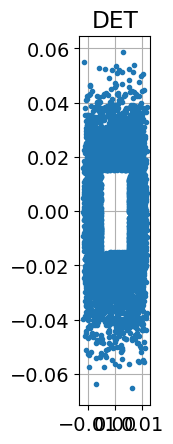

In [ ]:
for sec in section_data_lens:
    saved_collisions = sec.saved_collisions
    if len(saved_collisions) == 0:
        continue
    x, v = saved_collisions[-1]
    if len(x.x) > 1_000_000:
        continue
    if len(x.x) == 0:
        continue

    fig, ax = plt.subplots()
    ax.plot(x.x, x.y, ".")
    ax.set_title(sec.name)
    ax.set_aspect(1)
    ax.grid()


In [ ]:
print(
    f"lens gain = {section_data_lens[-1].survived / section_data_lens_0V[-1].survived:.2f}"
)


lens gain = 7.58


In [ ]:
interaction.start

1.72268

In [ ]:
sections_lens

[Section(name='SKIMMER', objects=[], start=0, stop=0.008255, save_collisions=False, propagation_type=<PropagationType.ballistic: 1>, force=None),
 Section(name='4K', objects=[CircularAperture(x=0, y=0, z=0.043179999999999996, r=0.0127)], start=0.043179999999999996, stop=0.08127999999999999, save_collisions=False, propagation_type=<PropagationType.ballistic: 1>, force=None),
 Section(name='40K', objects=[CircularAperture(x=0, y=0, z=0.08127999999999999, r=0.0127)], start=0.08127999999999999, stop=0.15113, save_collisions=False, propagation_type=<PropagationType.ballistic: 1>, force=None),
 Section(name='BEAMBOX', objects=[CircularAperture(x=0, y=0, z=0.15113, r=0.0508)], start=0.15113, stop=0.17018, save_collisions=False, propagation_type=<PropagationType.ballistic: 1>, force=None),
 Section(name='RC', objects=[], start=0.17018, stop=0.48768, save_collisions=True, propagation_type=<PropagationType.ballistic: 1>, force=None),
 Section(name='SPA', objects=[CircularAperture(x=0, y=0, z=0.8

In [ ]:
fourK.start, fourK.stop

(0.043179999999999996, 0.08127999999999999)

In [ ]:
fourtyK.start, fourtyK.stop

(0.08127999999999999, 0.15113)

In [ ]:
(beambox.start, beambox.stop)

(0.15113, 0.17018)

In [ ]:
(eql.start, eql.stop)

(0.80518, 1.40518)

In [ ]:
vi = []
vf = []
for traj in trajectories_lens.values():
    vi.append((traj.vx[0], traj.vy[0]))
    vf.append((traj.vx[-1], traj.vy[-1]))
vi = np.array(vi)
vf = np.array(vf)


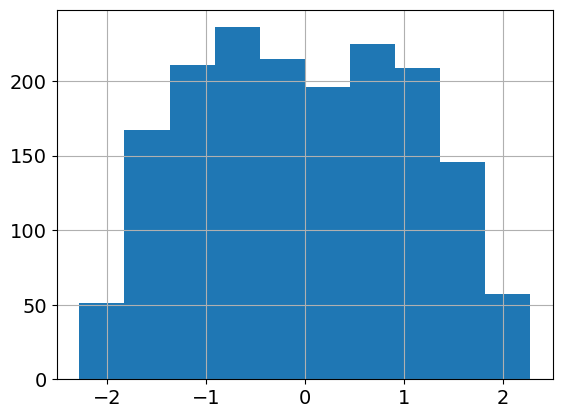

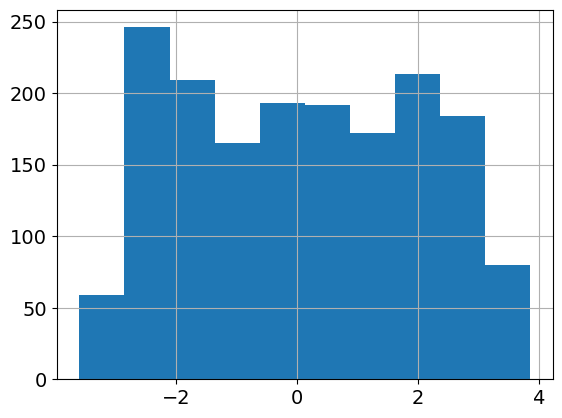

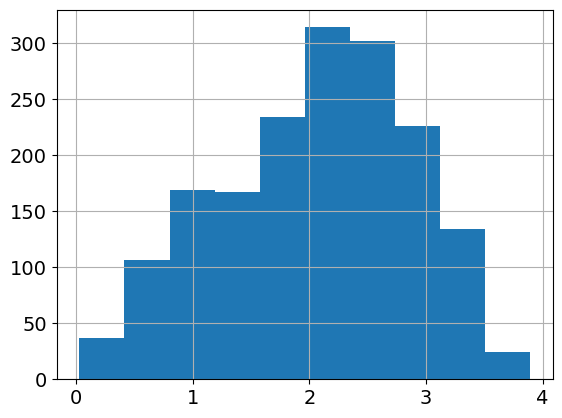

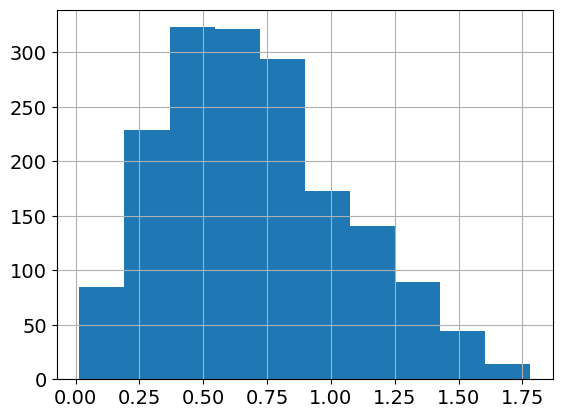

In [ ]:
fig, ax = plt.subplots()
ax.hist(vi[:, 0])
ax.grid()

fig, ax = plt.subplots()
ax.hist(vi[:, 1])
ax.grid()


fig, ax = plt.subplots()
ax.hist(np.sqrt(vi[:, 0] ** 2 + vi[:, 1] ** 2))
ax.grid()

fig, ax = plt.subplots()
ax.hist(np.sqrt(vf[:, 0] ** 2 + vf[:, 1] ** 2))
ax.grid()


# No lens and SPB

In [ ]:
interaction_nolens = Section(
    name="INT",
    objects=[
        PlateElectrodes(
            0,
            0,
            interaction_distance - eql_length - spb_length,
            length=interaction_length,
            width=10e-2,
            separation=2e-2,
        )
    ],
    start=interaction_distance - eql_length - spb_length,
    stop=spc_distance - eql_length - spb_length,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)

spc_nolens = Section(
    name="SPC",
    objects=[],
    start=spc_distance - eql_length - spb_length,
    stop=det_distance - eql_length - spb_length,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)

det_nolens = Section(
    name="DET",
    objects=[
        RectangularAperture(
            0,
            0,
            det_distance - eql_length - spb_length,
            aperture_det_width,
            aperture_det_height,
        )
    ],
    start=det_distance - eql_length - spb_length,
    stop=det_distance + 1e-3 - eql_length - spb_length,
    save_collisions=True,
    propagation_type=PropagationType.ballistic,
)


In [ ]:
sections_nolens = [
    cone,
    fourK,
    fourtyK,
    beambox,
    rc,
    spa,
    interaction_nolens,
    spc_nolens,
    det_nolens,
]
section_data_nolens, trajectories_nolens = propagate_trajectories(
    sections_nolens,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


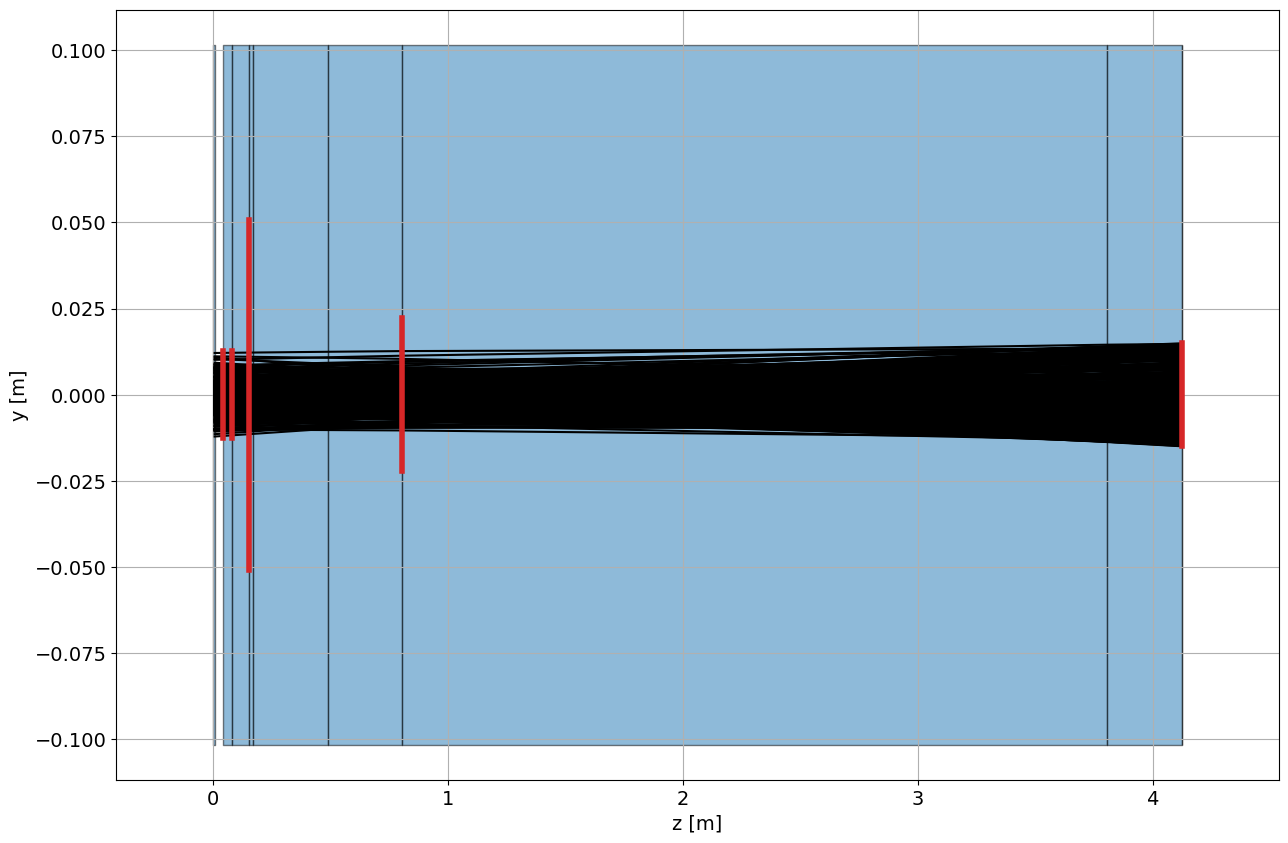

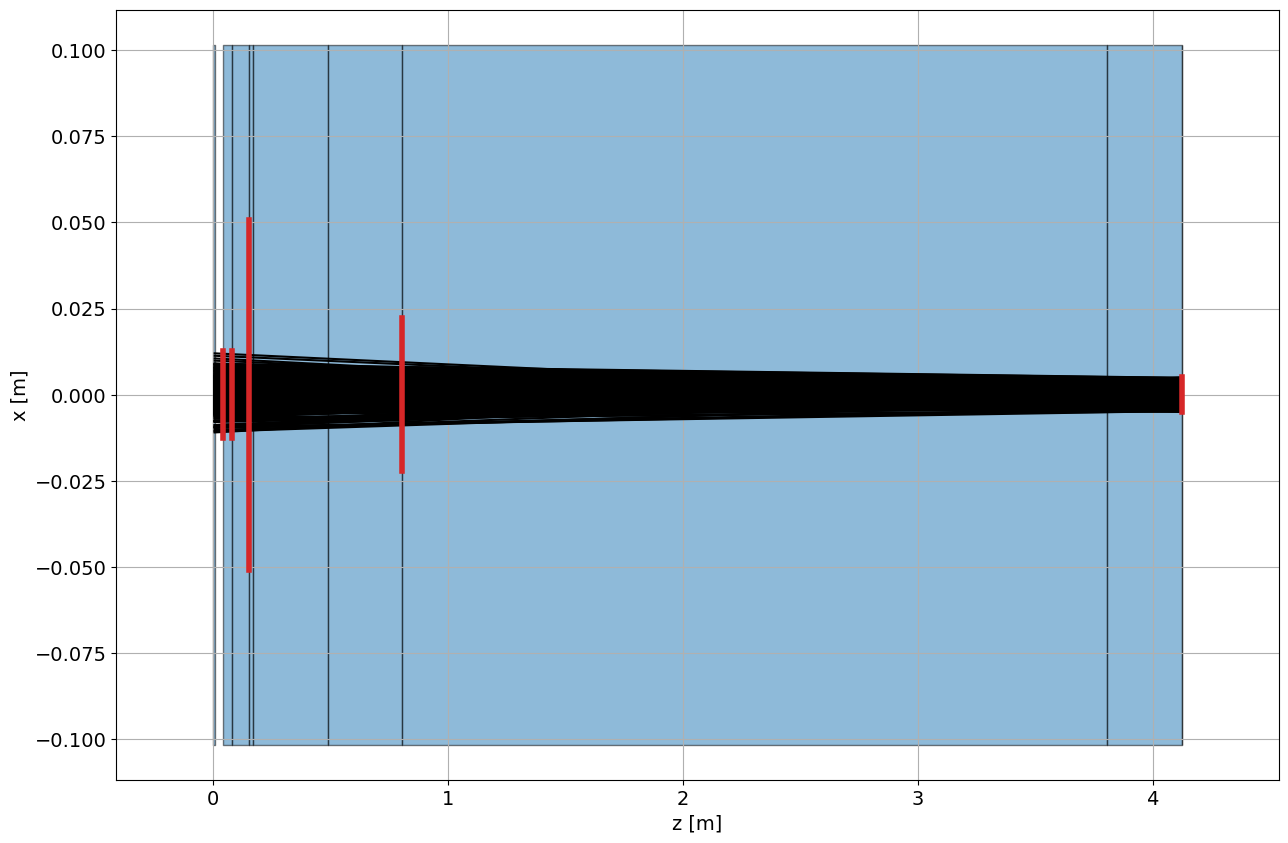

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_nolens.items():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections_nolens, ax=ax, axis="y")

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_nolens.items():
    ax.plot(traj.z, traj.x, color="k")

plot_beamline(sections_nolens, ax=ax, axis="x")

ax.set_xlabel("z [m]")
ax.set_ylabel("x [m]")

ax.grid(True)


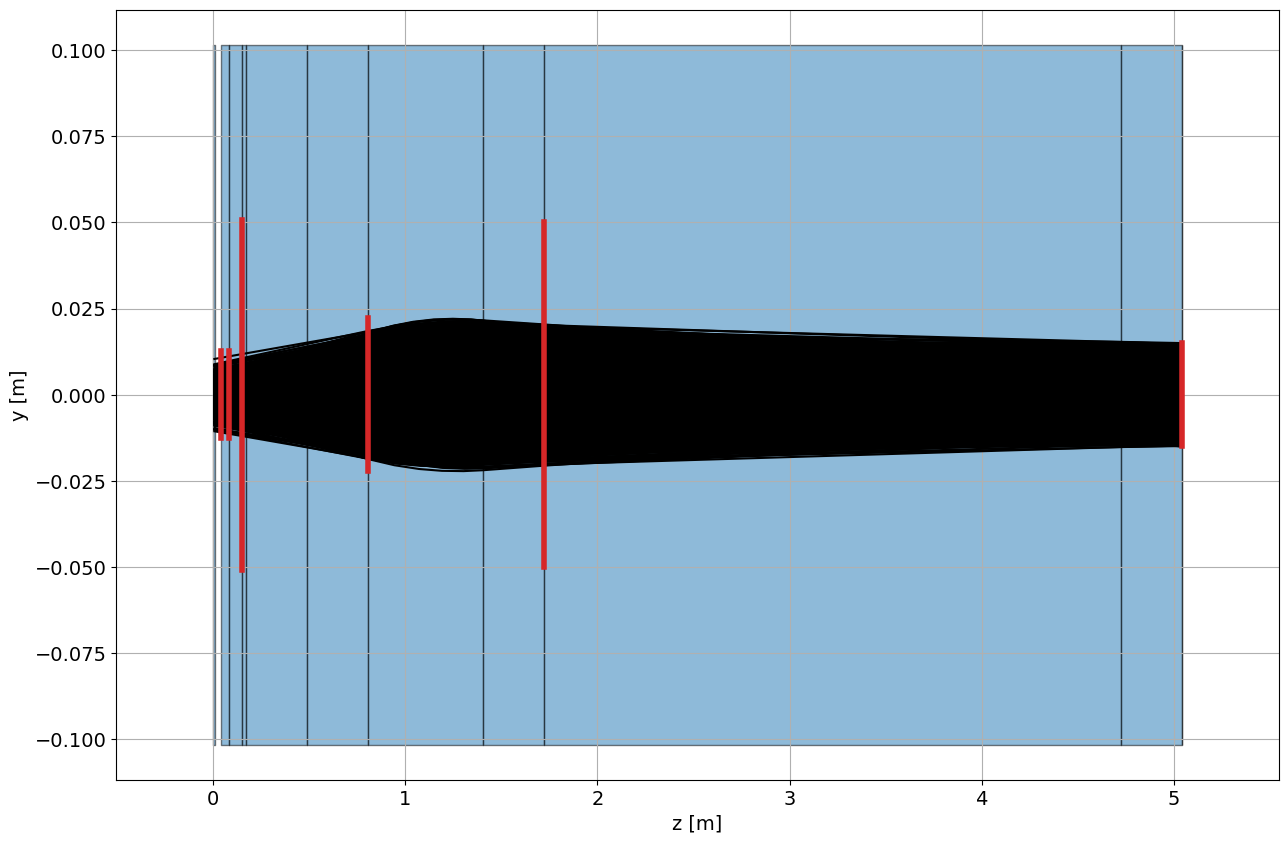

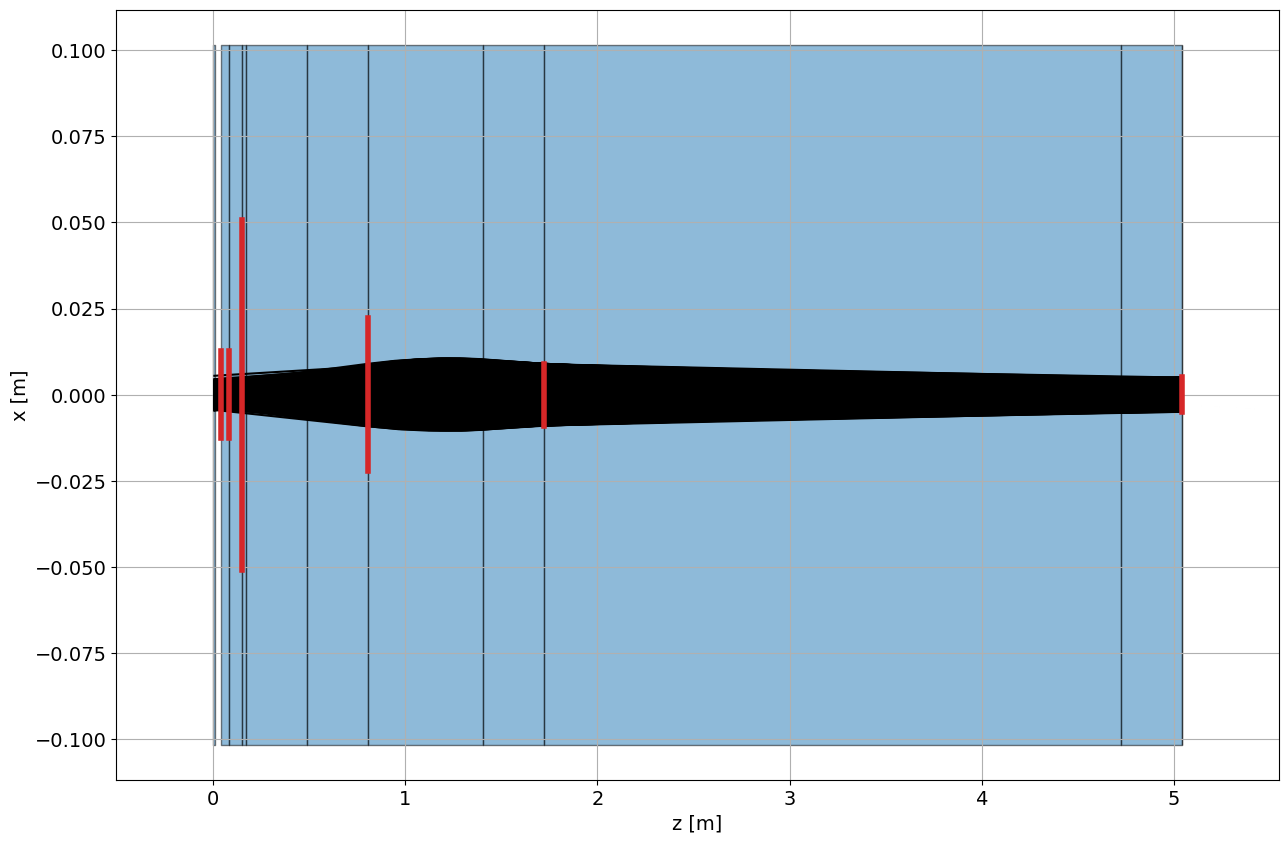

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_lens.items():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections_lens, ax=ax, axis="y")

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

fig, ax = plt.subplots(figsize=(15, 10))
for idt, traj in trajectories_lens.items():
    ax.plot(traj.z, traj.x, color="k")

plot_beamline(sections_lens, ax=ax, axis="x")

ax.set_xlabel("z [m]")
ax.set_ylabel("x [m]")

ax.grid(True)


# All gains calculated

In [ ]:
print(
    f"lens gain voltage = {section_data_lens[-1].survived / section_data_lens_0V[-1].survived:.2f}"
)
print(
    f"lens gain = {section_data_lens[-1].survived / section_data_nolens[-1].survived:.2f}"
)


lens gain voltage = 7.58
lens gain = 5.19


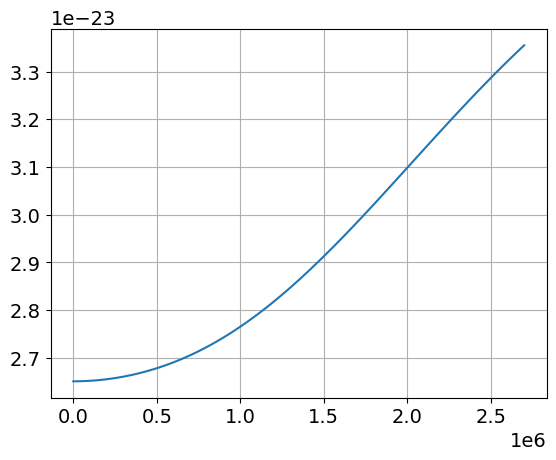

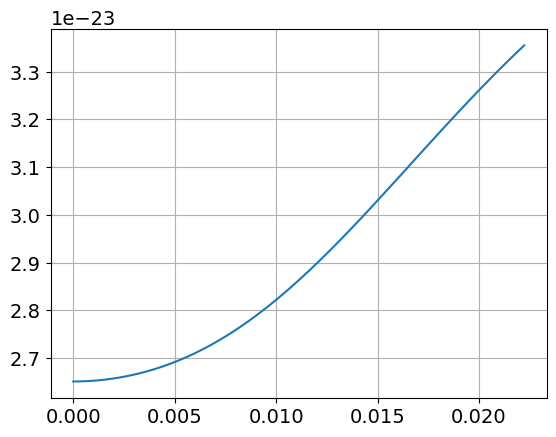

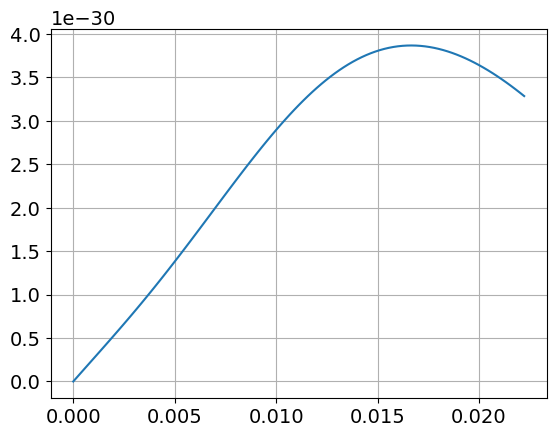

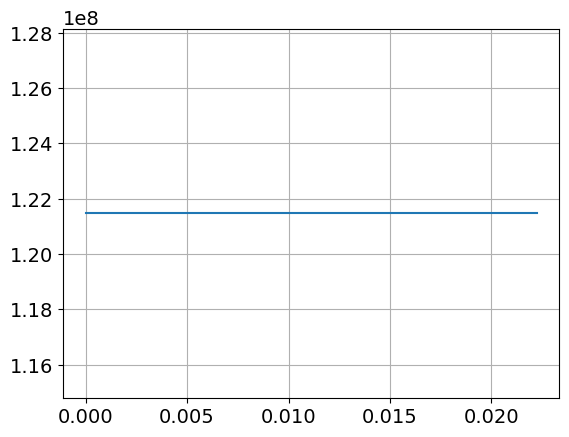

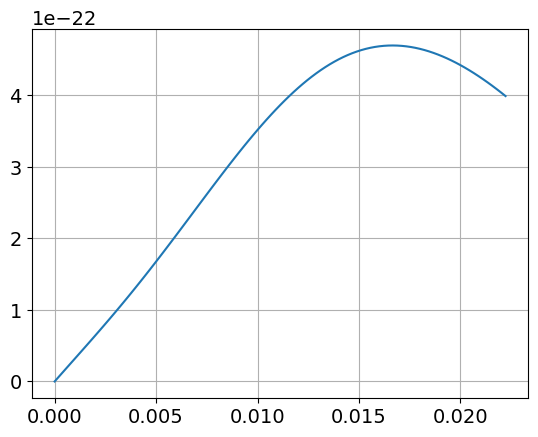

In [ ]:
r = np.linspace(0, eql_radius, 101)
stark_pot = eql.stark_potential(r, np.zeros(r.size), np.zeros(r.size))
stark_pot_derivative = eql.stark_potential_derivative(
    r, np.zeros(r.size), np.zeros(r.size)
)
efield_derivative = eql.electric_field_derivative_r(
    r, np.zeros(r.size), np.zeros(r.size)
)

fig, ax = plt.subplots()
ax.plot(eql.electric_field(r, np.zeros(r.size), np.zeros(r.size)), stark_pot)
ax.grid()

fig, ax = plt.subplots()
ax.plot(r, stark_pot)
ax.grid()


fig, ax = plt.subplots()
ax.plot(r, stark_pot_derivative)
ax.grid()

fig, ax = plt.subplots()
ax.plot(r, efield_derivative)
ax.grid()

fig, ax = plt.subplots()
ax.plot(r, efield_derivative * stark_pot_derivative)
ax.grid()


In [ ]:
from centrex_trajectories.utils import fit_stark_potential

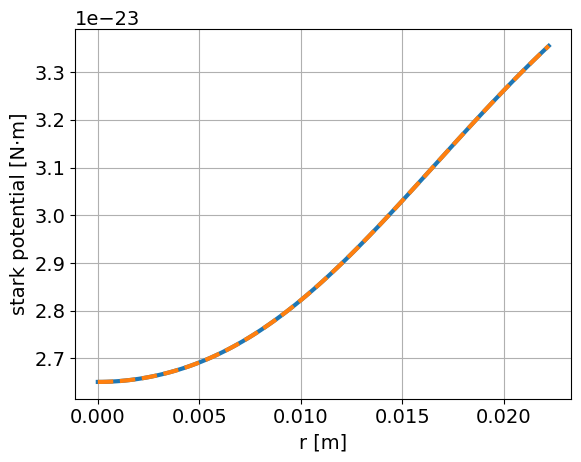

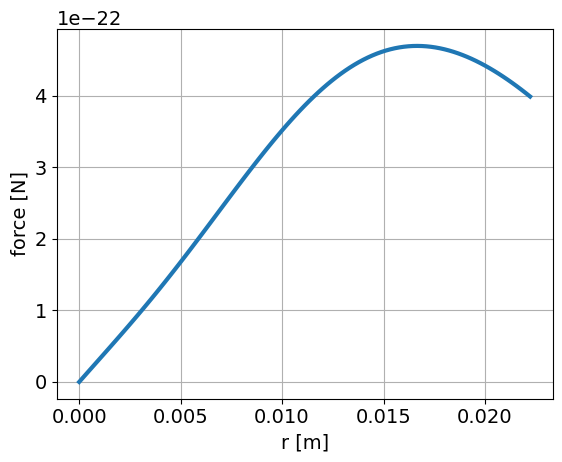

In [ ]:
y = eql.stark_potential(r, np.zeros(r.size), np.zeros(r.size))
fit_coeff = fit_stark_potential(r, y, deg=11)
fit = np.polynomial.Polynomial(coef=fit_coeff)

fig, ax = plt.subplots()
ax.plot(r, y, lw=3)
ax.plot(r, fit(r), "--", lw=3)

ax.set_xlabel("r [m]")
ax.set_ylabel("stark potential [N⋅m]")

ax.grid()

fig, ax = plt.subplots()
ax.plot(r, fit.deriv()(r), lw=3)

ax.set_xlabel("r [m]")
ax.set_ylabel("force [N]")

ax.grid()
